In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
import os
import json
import gzip
from urllib.request import urlopen

!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Amazon_Instant_Video_5.json.gz

--2020-07-07 05:37:00--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Amazon_Instant_Video_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9517526 (9.1M) [application/x-gzip]
Saving to: ‘reviews_Amazon_Instant_Video_5.json.gz’

reviews_Amazon_Inst 100%[===================>]   9.08M  2.22MB/s    in 4.1s    

2020-07-07 05:37:05 (2.22 MB/s) - ‘reviews_Amazon_Instant_Video_5.json.gz’ saved [9517526/9517526]



In [2]:
data = []
with gzip.open('reviews_Amazon_Instant_Video_5.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])

37126
{'reviewerID': 'A11N155CW1UV02', 'asin': 'B000H00VBQ', 'reviewerName': 'AdrianaM', 'helpful': [0, 0], 'reviewText': "I had big expectations because I love English TV, in particular Investigative and detective stuff but this guy is really boring. It didn't appeal to me at all.", 'overall': 2.0, 'summary': 'A little bit boring for me', 'unixReviewTime': 1399075200, 'reviewTime': '05 3, 2014'}


In [3]:
df = pd.DataFrame.from_dict(data)

print(len(df))


37126


In [4]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [5]:
df.tail()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
37121,A1ELO9LMSE1CQ7,B00LPWPMCS,Mpr90,"[0, 0]",I love the books! The show is amazing so far. ...,5.0,Great Series!,1405728000,"07 19, 2014"
37122,AGOEKVIJV9UX6,B00LPWPMCS,Mr. Markster,"[13, 15]","""The Strain"" has potential to be an excellent ...",5.0,Forget the Vampire Diaries -- This is a REAL V...,1405296000,"07 14, 2014"
37123,A3I291BE0RNZCU,B00LPWPMCS,Rating My Best Pick,"[0, 2]","I'm not real sure on how, I should rate this s...",3.0,It's only the first episode so I'm not real su...,1405296000,"07 14, 2014"
37124,A1MNITZRYU71IO,B00LPWPMCS,"Sherry ""trying in ohio""","[1, 1]",episode one so far makes me want to watch more...,4.0,and that is good. The accents are a bit much h...,1405296000,"07 14, 2014"
37125,A1XMHK9HN5MW2H,B00LPWPMCS,Victoria J. Dennison,"[3, 4]",I watched the pilot. I guess I've just seen t...,3.0,I may have paid towatch the pilot,1405468800,"07 16, 2014"


In [23]:
df.apply(np.random.shuffle, axis=0)

df.tail()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,user,movie,rating
16850,A300SS3LT4L0S3,B009AP2G26,"AllMyShelties ""AllMyShelties""","[0, 0]","I wasn't sure that I would like this series, b...",5.0,Wonderful show!!,1389312000,"01 10, 2014",4385,866,5.0
6265,A37KQ2QVXLNYP3,B003V61JUK,Richard C. Anderson,"[0, 0]",Started watching this and got hooked on the ch...,5.0,Entertaining cop show,1402876800,"06 16, 2014",1551,341,5.0
11284,A38AW6NENLK69V,B0068ZCCA2,"Paula S. Smith ""ChefPaula1965""","[0, 0]",This is a fun show to watch with young teen ag...,4.0,My son loves this show,1367107200,"04 28, 2013",1909,604,4.0
860,A25KKXUQQ0OLWB,B000OGTRC2,"Lynn Ellingwood ""The ESOL Teacher""","[0, 0]","When I first watched the pilot, I saw too many...",5.0,Grows On You and Then Becomes a Classic,1344729600,"08 12, 2012",285,45,5.0
15795,A2VJLXWCSF2CG5,B008QTTGGG,Steven Javorniczky,"[0, 0]","This show just gets better and better, the sto...",5.0,Grimm's fairytales,1384819200,"11 19, 2013",3715,822,5.0


In [24]:
user_ids = df["reviewerID"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["asin"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["reviewerID"].map(user2user_encoded)
df["movie"] = df["asin"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["overall"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 5130, Number of Movies: 1685, Min rating: 1.0, Max rating: 5.0


In [25]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)


In [26]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)


In [30]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)


Epoch 1/5
523/523 [==============================] - 2s 5ms/step - loss: 0.6684 - val_loss: 0.6271
Epoch 2/5
523/523 [==============================] - 2s 4ms/step - loss: 0.5172 - val_loss: 0.4988
Epoch 3/5
523/523 [==============================] - 2s 4ms/step - loss: 0.4903 - val_loss: 0.4947
Epoch 4/5
523/523 [==============================] - 2s 4ms/step - loss: 0.4847 - val_loss: 0.4899
Epoch 5/5
523/523 [==============================] - 2s 4ms/step - loss: 0.4797 - val_loss: 0.4814


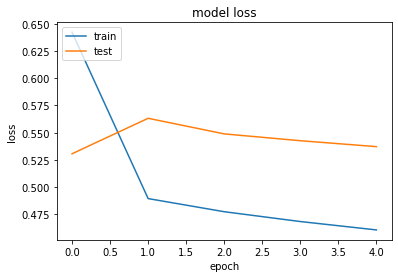

In [28]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [29]:

model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.RMSprop(lr=0.001)
)

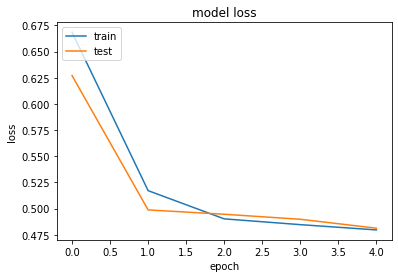

In [31]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()